In [1]:
from z3 import *


Z3 proofs.
They look more readable than I remember?
Maybe I was asking hard questions or they got better?
Graphviz output. Whaaaaaaa. That's crazy.

Kind of nice.
Basically rewriting proofs are a bunch of trasntitivty rewrites
We could 

I reduced cateogry theory to guarded equalities.
This "might" be ok. I really do need to inspect the proof the be certain

These things are constrained hron clauses. So that might be cool.
( = 

The proof printer is just using a generic AST to graphviz feature

Wait. Is the way the proof system works by storing it in the egraph
The ML documentation by far has the best desciption of the proof fomrat

https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/nbjorner-iwil08.pdf paper

In [30]:
from z3 import *
set_param(proof=True)
s = Solver()
x = Int("x")
s.add(x == 1)
s.add(x == 2)
s.check()
dir(s.proof())
#print(s.proof().sexpr())
s.proof().children()
s.proof().decl().domain(2)
#dir(s.proof().decl())
s.add(s.proof() == s.proof()) # woah. I can internalize the proof objects.
s.check()
s.proof()
simplify(And(x == 1, s.proof() == s.proof()))
# I could add definitions to modus ponens and stuff.
# maybe use z3 itself to interpet them?
# I don't know what to do with this, but I bet I could do something pretty crazy.


x == 1

In [80]:
s = Solver()
s.add(Not(x + x == 2 * x))
s.check()
s.proof()

mp(asserted(Not(x + x == 2*x)),
   trans(monotonicity(trans(monotonicity(rewrite(x + x ==
                                        2*x),
                                        (x + x == 2*x) ==
                                        (2*x == 2*x)),
                            rewrite((2*x == 2*x) == True),
                            (x + x == 2*x) == True),
                      Not(x + x == 2*x) == Not(True)),
         rewrite(Not(True) == False),
         Not(x + x == 2*x) == False),
   False)

In [78]:
simplify( Implies( And(axioms) ,   comp(id(a),comp(id(a), f)) == f ), rewrite_patterns=True)
help_simplify()

algebraic_number_evaluator (bool) simplify/evaluate expressions containing (algebraic) irrational numbers. (default: true)
arith_ineq_lhs (bool) rewrite inequalities so that right-hand-side is a constant. (default: false)
arith_lhs (bool) all monomials are moved to the left-hand-side, and the right-hand-side is just a constant. (default: false)
bit2bool (bool) try to convert bit-vector terms of size 1 into Boolean terms (default: true)
blast_distinct (bool) expand a distinct predicate into a quadratic number of disequalities (default: false)
blast_distinct_threshold (unsigned int) when blast_distinct is true, only distinct expressions with less than this number of arguments are blasted (default: 4294967295)
blast_eq_value (bool) blast (some) Bit-vector equalities into bits (default: false)
blast_select_store (bool) eagerly replace all (select (store ..) ..) term by an if-then-else term (default: false)
bv_extract_prop (bool) attempt to partially propagate extraction inwards (default: f

In [88]:
Type = DeclareSort("Type")


Ob = DeclareSort("Ob")
Morph = DeclareSort("Morph")

ObT = Const("Ob", Type)
HomT = Function("Hom", Ob, Ob, Type)

typhom = Function("typh", Morph, Type)
cod = Function("cod", Type, Ob)
dom = Function("dom", Type, Ob)

a,b,c = Consts("a b c", Ob)
f,g,h = Consts("f g h", Morph)

id = Function("id", Ob, Morph)
comp = Function("comp", Morph, Morph, Morph)

axioms = [
    #ForAll([f,a], Implies(dom(typ(f)) == a  , f == comp(id(a), f)  ),
    #       
    #      patterns=[ comp(id(a), f) ])
    
    ForAll([f,a],  f == comp(id(a), f),
           
          patterns=[ comp(id(a), f) ])
    
]

s = Solver()
s.add(axioms)
s.add(Not( comp(id(a),comp(id(a), f)) == f   ))

s.check()
print(s.proof().sexpr())


# If I just printed trans, and quant-inst.

Proof = s.proof().sort()

def build_tree(proof):
    if proof.sort() != Proof:
        return proof
    else:
        #print(len(proof.children()))
        #if len(proof.children()) == 1:
        #    print(proof.decl())
        return (proof.decl(), list(map(build_tree, proof.children())))
    
def get_quant_inst(proof):
    if proof.sort() != Proof:
        return []
    else:
        d = proof.decl().name()
        if d == "unit-resolution" and proof.arg(0).decl().name() == "quant-inst": # "quant-inst":
            #print(proof.children())
            return proof.children()[2]
        #print(len(proof.children()))
        #if len(proof.children()) == 1:
        #    print(proof.decl())
        return  list(map(get_quant_inst, proof.children()))
    
#build_tree(s.proof())
#s.proof().decl().name()
get_quant_inst(s.proof())

def simplify_proof(proof):
    if proof.sort() != Proof:
        return proof
    else:
        d = proof.decl().name()
        if d == "unit-resolution" and proof.arg(0).decl().name() == "quant-inst": # "quant-inst":
            #print(proof.children())
            return ("ax-inst", proof.children()[2])
        elif d == "symm": # No we do not care about this
            return simplify_proof(proof.arg(0))
        if d == "rewrite" and proof.arg(0).arg(0) == proof.arg(0).arg(1):
            return "refl"
        #print(len(proof.children()))
        #if len(proof.children()) == 1:
        #    print(proof.decl())
        return (proof.decl() , list(map(simplify_proof, proof.children())))
    # remove rewrite to rewrite rules.
    # (mp )
simplify_proof(s.proof())

(let ((a!1 (= (comp (id a) (comp (id a) f)) f))
      (a!3 (forall ((f Morph) (a Ob))
             (! (= f (comp (id a) f)) :pattern ((comp (id a) f)))))
      (a!4 (= (comp (id a) f) (comp (id a) (comp (id a) f))))
      (a!10 (= (comp (id a) (comp (id a) f)) (comp (id a) f))))
(let ((a!2 (mp (asserted (not a!1)) (rewrite (= (not a!1) (not a!1))) (not a!1)))
      (a!5 (nnf-pos (proof-bind (lambda ((f Morph) (a Ob))
                                  (let ((a!1 (~ (= f (comp (id a) f))
                                                (= f (comp (id a) f)))))
                                    (refl a!1))))
                    (~ a!3 a!3)))
      (a!8 (or (not a!3) (= f (comp (id a) f)))))
(let ((a!6 (mp~ (mp (asserted a!3) (rewrite (= a!3 a!3)) a!3) a!5 a!3)))
(let ((a!7 (unit-resolution (quant-inst (or (not a!3) a!4)) a!6 a!4))
      (a!9 (unit-resolution (quant-inst a!8) a!6 (= f (comp (id a) f)))))
(let ((a!11 (symm (trans (monotonicity a!9 (= a!1 a!10))
                         (co

(unit-resolution,
 [(mp,
   [(asserted, [Not(comp(id(a), comp(id(a), f)) == f)]),
    'refl',
    Not(comp(id(a), comp(id(a), f)) == f)]),
  (mp,
   [('ax-inst', comp(id(a), f) == comp(id(a), comp(id(a), f))),
    (trans,
     [(monotonicity,
       [('ax-inst', f == comp(id(a), f)),
        (comp(id(a), comp(id(a), f)) == f) ==
        (comp(id(a), comp(id(a), f)) == comp(id(a), f))]),
      (commutativity,
       [(comp(id(a), comp(id(a), f)) == comp(id(a), f)) ==
        (comp(id(a), f) == comp(id(a), comp(id(a), f)))]),
      (comp(id(a), comp(id(a), f)) == f) ==
      (comp(id(a), f) == comp(id(a), comp(id(a), f)))]),
    comp(id(a), comp(id(a), f)) == f]),
  False])

In [10]:
S = DeclareSort("S")
f = Function("f", S, S)
x = Const("x", S)
s = Solver()
#s.add(ForAll(x, f(f(f(x))) == x))
s.add(ForAll(x, f(f(x)) == x)) # a rule
s.add( f(f(x)) == x ) # an initialization statement
#s.add( f(x) == f(x) ) # an initialization statement
s.check()
s.model()
# i need an example where the graph does not terminate
type(f)

z3.z3.FuncDeclRef

In [ ]:
fspace = DeclareSort("fspace")
sumy = Function("sum", IntSort(), )

In [ ]:
a = DeclareSort("a")
b = DeclareSort("ab")

munit = ""
a = "a"
b = "b"

def id(a):
    O = DeclareSort(a)
    H = DeclareSort(f"hom({a},{a})")
    Const( "id" , H)
    return Function("id", O, H) # Function("")
    Function("id", Ob, Hom)(a)

for ob in [munit, a , b]**n, 
  if type_checks
    s.add( ForAllid(a) . f = f )

    

I've been really fascinated by the work of egg https://egraphs-good.github.io/

My understanding is the model returned by Z3 for uninterpreted sorts is basically a serialization of the egraph. Despite the spiealization of egg to this problem, there do seem like there are advantages to using Z3 for very similar use cases, not the least of which are the already very extensive language bindings. In addition, access to information of this sort may be useful in an ordinary use of Z3 in terms of debugging quantifier instantiation and triggers.

The ematching engine of Z3 is accessed via ForAll quantifiers with trigger patterns. As far as I know, as soon as I start using ForAll quantifiers, there is no way to receive a partially built model from Z3. 

Is there some api or trick by which a partial egraph can be output from Z3?

In [42]:
#parse_smt2_string( " (declare-const x Int)  (assert (= x 0)) " )
from z3 import *
e = parse_smt2_string('(declare-const x Int) (assert (> x 0)) (assert (< x 10))')
type(e)

z3.z3.AstVector

In [22]:
from z3 import *
B = BoolSort()
p, q,r = Bools("p q r")
mand = Function("And",B, B, B )
mor = Function("Or",B, B, B )
meq = Function("Eq", B, B, B)
mnot = Function("Not",B,B)

axioms = [
    #ForAll([x,y], mand(x,y) == And(x,y) )
    # equanamity from gries is the only one we don't get by default
    #ForAll( [p,q] , And(p == q, p) => q  )
    mnot(True) == False,
    ForAll([p,q], mnot(p == q) == (mnot(p) == q)),
    ForAll([p,q], mor(p , q) == mor(q, p)),
    ForAll([p], mor(p , p) == p),
    ForAll([p,q,r], mor(p , q == r) == (mor(p,q) == mor(p, r))),
    ForAll([p],  mor(p, mnot(p) ) )
    
    #ForAll([p,q], mand(p , q) == mand(q, p)),
    #ForAll([p,q], mand(p , q) == mand(q, p)),
    
]

s = Solver()
s.add(axioms)
#s.add( mnot(False) == True  )
s.check()
s.model()

[Or = [else ->
       Or(And(Not(Var(0)), Var(1)),
          And(Var(0), Var(1)),
          And(Var(0), Not(Var(1))))],
 Not = [else -> Not(Var(0))]]

In [38]:
G = DeclareSort("G")
e,a,b,c = Consts("e a b c", G)
times = Function('*', G,G, G)

monoid_axioms = [
  ForAll([a], times(e,a) == a ),
  ForAll([a], times(a,e) == a ),
  ForAll([a,b,c] , times(a,times(b,c)) == times(times(a,b),c))
]

# A simple theorem
s = Solver()
s.add(axioms)
theorem = inv(times(a,b)) == times(inv(b), inv(a))
s.add(Not(theorem))
s.check()

NameError: name 'inv' is not defined

In [ ]:
z

In [ ]:
# HOL to Z3


types_dict = {}


def function(name, *types):
    out = types[-1]
    ins = types[:-1]
    if types in type_dict:
        ty = type_dict[types]
        
    # return defunctionalized thingo
    axioms = [] #fully applied everything.
    apply(f(a),b) == f(a,b)
    f(a,b,c,d)
    f2 == apply(f1(a), b)
    f3(c , f2(b, f1(a)) # fuse out apply. It's curried, fine.
       # but then how do you do higher order stuff?
    return lambda x : 
    map( f , x ) == apply(f,x)
    def res(*args):
        
        
    




In [79]:
fp = Fixedpoint()

a, b, c = Bools('a b c')

fp.register_relation(a.decl(), b.decl(), c.decl())
fp.rule(a,b)
fp.rule(b,c)
fp.set(engine='datalog')

print("current set of rules\n", fp)
print(fp.query(a))

fp.fact(c)
print("updated set of rules\n", fp)
print(fp.query(a))
print(fp.get_answer())

current set of rules
 (declare-rel b ())
(declare-rel a ())
(declare-rel c ())
(rule (=> (and b) a))
(rule (=> (and c) b))

unsat
updated set of rules
 (declare-rel b ())
(declare-rel a ())
(declare-rel c ())
(rule (=> b a))
(rule (=> c b))
(rule c)

sat
True


In [80]:
fp = Fixedpoint()
fp.set(engine='datalog')

s = BitVecSort(3)
edge = Function('edge', s, s, BoolSort())
path = Function('path', s, s, BoolSort())
a = Const('a',s)
b = Const('b',s)
c = Const('c',s)

fp.register_relation(path,edge)
fp.declare_var(a,b,c)
fp.rule(path(a,b), edge(a,b))
fp.rule(path(a,c), [edge(a,b),path(b,c)])

v1 = BitVecVal(1,s)
v2 = BitVecVal(2,s)
v3 = BitVecVal(3,s)
v4 = BitVecVal(4,s)

fp.fact(edge(v1,v2))
fp.fact(edge(v1,v3))
fp.fact(edge(v2,v4))

print("current set of rules", fp)


print(fp.query(path(v1,v4)), "yes we can reach v4 from v1")

print(fp.query(path(v3,v4)), "no we cannot reach v4 from v3")

current set of rules (declare-rel path ((_ BitVec 3) (_ BitVec 3)))
(declare-rel edge ((_ BitVec 3) (_ BitVec 3)))
(declare-var A (_ BitVec 3))
(declare-var B (_ BitVec 3))
(declare-var C (_ BitVec 3))
(rule (=> (and (edge C B)) (path C B)))
(rule (=> (and (edge C B) (path B A)) (path C A)))
(rule (edge #b001 #b010))
(rule (edge #b001 #b011))
(rule (edge #b010 #b100))

sat yes we can reach v4 from v1
unsat no we cannot reach v4 from v3


In [ ]:
x = Int("x")


set1 = x >= 2 # The set of all integers greater than or equal to 2
set2 = x < 0 # The set of all integers less than zero

# What is the union
union12 = None

# what is the intersection?
intersection12 = None

# What is the complement of set1?
complement1 = None


#Asking for subset
s1 = x > 0
s2 = x > 1
prove(Implies(  s2 , s1  )) # is s2 a susbset of s1?

x = Int("x")
evens = x % 2 == 0
odds = x % 2 == 1

solve(And(evens, odds))
solve(Or(evens, odds))

In [ ]:
from z3 import *

a,b,c = Ints('a b c')
post = a == 4 * c
p1 = substitute(post, ( a , 2 * b) )
p2 = substitute(p1, ( b , 2 * a) )
p3 = substitute(p2, (a, c))
print(p3)

#https://en.wikipedia.org/wiki/Predicate_transformer_semantics

# collects up all the variable from a formula
# https://stackoverflow.com/questions/14080398/z3py-how-to-get-the-list-of-variables-from-a-formula
def get_vars(f):
    r = set()
    def collect(f):
      if is_const(f): 
          if f.decl().kind() == Z3_OP_UNINTERPRETED:
              r.add(f)
      else:
          for c in f.children():
              collect(c)
    collect(f)
    return r


# set
def seq(s1,s2):
    return lambda post: s1(s2(post))
def set_(v, e):
    return lambda post: substitute(post,(v, e))
def if_(i, t, e):
    return lambda post: Or(Implies(i, t(post)) , And(Not(i), e(post)))

skip = lambda post: post
abort = lambda post: BoolVal(False)
# assert, assume

def assert_(prop):
    return lambda post: And(post, prop)
def assume_(prop):
    return lambda post: Implies(prop, post)

def while_(cond, inv, *body): # ooh, what if we made *body
    def res(post):
        vs = list(get_vars(post))
        return And( inv , 
        ForAll(vs, And( Implies( And(cond, inv), begin(*body)(inv))
                        , Implies( And(Not(cond), inv), post) )))
    return res

# For a fixed for loop, just unroll it.
def for_(i, start,end, body):
    def res(post):
        wp = post
        for ival in reversed(range(start,end)):
            wp = seq( assign(i, IntVal(ival)), body )(wp)
        return wp
    return res
def for_2(i, start,end, inv, *body):
    return seq(
        assign(i, start),
        while_( i != end , inv, seq(body, assign(i, i + 1)))
    )

def begin(*args):
    def res(post):
        wp = post
        for s in reversed(args):
            wp = s(wp)
        return wp
    return res

def debug(post):
    print(post)
    return post

def verify_fun(pre, post, body):
    prove(Implies(pre, body(post)))
'''
if a%2 == 0:
    pass
else:
    a := a + 1
'''

prove(ite(a%2 == 0,  skip    , assign(a, a+2))(Exists([b],a == 2*b)))


#seq(assign(a, 2*b))
prog = begin(
   assign(a,2*b) ,
   assign(a,2*a) ,   
)

prog(a >= 4)

# This form may be more familiar.
def wp(stmt, post):
    if isinstance(stmt, Assign):
        pass
    elif isinstance(stmt, ):
        pass

    
prog = begin(
           assign(b, IntVal(0)),
           for_(a, 0, 3,
               assign(b,  b + a)
           )
       )

prove(prog(b == 3))



# The above is kind of a finally tagless style + curried form of wp.
# If I imported *, how horrible would that be? Maybe very
i, n = Ints("i n")
prog = begin(
    assign(a, IntVal(0)),
    assign(i, IntVal(0)),
    while_(i != n   , a == n*i,
        begin(
         assign(i, i + 1),
         assign(a, a + n)
        )
        )
)


prove(simplify( Implies( n >= 0 , prog(a == n*n))))
prove( Implies( n >= 0, prog(a == n*n)))


def square(n):
    a = 0
    i = 0
    while i < n:
        i = i + 1
        a = a + n
    return a

i, n = Ints("i n")
prog = begin(
    assign(a, IntVal(0)),
    assign(i, IntVal(0)),
    while_(i < n   , And(i < n + 1, 0 <= i, a == n*i),
         assign(i, i + 1),
         assign(a, a + n)
        )
)
#prove( Implies( n >= 0, prog(a == n*n)))
#prove(Implies(And(i == n, a == n * i), a == n * n))

verify_fun( n >= 0 , a == n * n,  prog )









# compile time vs runtime. The unrolling of loops. It's kind of the same issue.

post = a == 4
prog = set_(a,IntVal(4))
pre = prog(post)
prove(pre)


def twosort(a,b):
    if b < a:
        temp = a
        a = b
        b = temp
    else:
        pass
    return a,b

temp = Int("temp")
prog = \
if_(b < a,
    begin(
         assign(temp,a),
         assign(a,b),
         assign(b, temp)
         ),
    skip
   )

verify_fun(True, a <= b, prog)

prog = \
if_(b < a,
    assign(a,b),
    skip
   )

# also true, but not a sort.
verify_fun(True, a <= b, prog)


# Simple program equiavalence

prog1 =  \
begin(
         assign(temp,a),
         assign(a,b),
         assign(b, temp)
         )

c, d = Ints('c d')
prog2 = \
begin(
    assign(c, d - c),
    assign(d, d - c),
    assign(c, c + d)
)

verify_fun( And(a == c, b == d), And(a == c, b == d), seq(prog1,prog2))

#fib = Function("fib", IntSort(),IntSort())
#fibdef = ForAll([a], fib(a) == If(a <= 0, 0, If(a == 1, 1, fib(a-1) + fib(a - 2))))

#prog = \

sumn = Function("sumn", IntSort(),IntSort())
sumndef = ForAll([a], sumn(a) == If(a <= 0, 0, sumn(a-1) + a))

prog = \
begin(
assign(i, IntVal(0)),
while_(i != n+1,  a == sumn(i)  ,
      assign(i, i + 1),
      assign(a, a + i)
      )
)



#verify_fun(And(sumndef, n >= 0), sumn(n) == a, prog )



prove( Implies(And(sumndef,  a == sumn(i), i == n), sumn(n) == a))
prog(sumn(n) == a)



# Verifying function calls. We need to assert the weakest precondition of the inputs to the function
'''
Alan Turing 1949 first proof of a program
u := 1
for r = 0 to n - 1 do
        v := u
    for s = 1 to r do
        u := u + v

# needs not unrolled for loop. :(
begin(
assign(u, 1),
fory( r,0, n, 
     begin(
      assign(v,u),
      fory(s, 1, r,
          assign(u, u + v)
          )
     )
    ),
)


assign(a, 0)
assign(i, 0)
whiley(i < n  , a == n*(i - 1),
     assign(i, i-1)
     assign(a, a + n)
  )


def square(n):
    a = 0
    i = 0
    while i < n:
        i = i -1
        a = a + n
    return a

post = a == n*n




def twosort(a,b)
    if a <= b:
        temp = a
        a = b
        b = temp
    else:
        pass
    return a,b




'''


ite( a <= b, 
   begin(
       assign(temp,a),
       assign(a,b),
       assign(b, temp)
   ), 
   skip
   )


twosort(2,1)

I have some idea of a set of transformations that needs to happen to some data, or a sequence of actions that need to be sent out. Request to this URL, parse out the json update the screen, that kind of thing. Or I need to go through each element of this structure and increment this field. 

The data of the program exists in different states throguhout the code. So the 
The CPU and memory are also these stateful machines , but I reason in this vague . I do not have the manual of any programming language memorized by heart and you can catch me on gotchas of the standards.

Each statement of the program changes the state in some way. A new value is stored in some variable, or the execution jumps to a new point in code.


Differential equations + Z3

We can differentiate expressiosn
We can integrate expressions


We can call Z3. get models



Differential equations are unfortunately unbounded loops. They're hard to unroll. I guess we could anyway and just say F-it.
Espcially if you combined it with an error estimate.
Any returned countermodel would be super suspicious.
Unsats are roughly as trustable as naive BMC unsats



diff(x) ->  (x_{n + 1} - x_n) / dt


hand it off to sympy


bnouncing ball

x,v = Real("x v")
dt = 0.1

dyn = And(prime(x) == If(x + v * dt <= 0, 0, x + v * dt),
prime(v) == If(x == 0, -v, v + g*dt))
Spec = x >= 0 & v <= v0
Init = And(x <= 1, v == 0)


What about fully eager dpll?

class MySolver(Solver)
    def add():
    def check():
    def 

What about differential equations as surfaces.

dx* ==    *dy


has to be linear, so could replace d with complete basis at compile time.


PC is the explici time parameter.
t

dt*x == dx 

dx == -x*dt

dx2 = -(x + dx)*dt2


prime(t) == t + dt
prime(x) = x + dx
dx == -x * dt






integral as special symbol
integ(x) \sub 


 [ Interval() for i in range(n)]
integ(tube) = [ dt*  ]


How do we 

what about the "subgradient". We could consider the derivative to be kind of a cone.



In [10]:

from z3 import *

x, y = Reals("x y")
a, b = Ints("a b")

p, q = Bools("p q")
def Conseq(p,q):
    return Implies(q,p)

th = Implies( Not(p), q )   ==  Conseq(p, Not(q)) # galois connection
prove(  th)


#(x,y) <= (y,x)

# ToInt is floor
th = ( a <= ToInt(x) )   ==  ( ToReal( a ) <= x)  # galois connection
prove( th )




proved
proved


In [ ]:
# bauer suggests a method for computing truth of logical statements about the reals
# An upper and lower predicate.



cut(x, left, right)




Set theoyr.
Can use functions to represent sets. 
Other interesting suggestins from de Moura:
https://stackoverflow.com/questions/17706219/defining-a-theory-of-sets-with-z3-smt-lib2
converting sets as functions to sets as objects is an example of defunctionaolziation
same for Function <=>  apply(F, x) == F(x)
And currying.


S = Function("S", A, BoolSort())
U = Function("U", A, BoolSort())
def union(u,v):
    return lambda x: Or(u(x) , v(x )
def intersection(u,v):
    return lambda x: And(u(x), v(x))
def difference
def preimage(u,f):
    lambda x : u(f(x))
def image(u,f):
    return lambda x: Exists([y], And(x == f(y), u(y))
def elem(x,f):
    return f(x)
def subset(f,g):
    return ForAll([x], Implies(g(x), f(x)))
def prod(f,g) -> Callable[ Tuple[z3[A], z3[B]], z3[bool] ]:
    lambda (x,y): And(f(x), g(x))  


what about an open set?
Sierp = Emp, T, All
All logical connectives need to be redefined
Do function need to be made monotonic or something?





# Embedding other logics

Seperation logic,
Modal logic
temporal logic

It seems that really I'm not going to be proving, I'm model finding or model checking

unintepreted sort

Kripke model:
Worlds = DeclareSort("Worlds")
propQ = Function("Q", World, Bool) # each propsition symbol is now predicated upon world
Transrelation = DelareSort("T", World, World, Bool) #



In [ ]:
# sepewration logic in z3
# cvc4 natively supports sep logic

heap = Function("heap", IntSort(), IntSort()) # or bitvec?

#https://stackoverflow.com/questions/52313122/map-data-structure-in-z3

# hmmm

# TupleSort


emp = 

# setadd, SetDel,m SetDifference, SetHasSize, emptyset, fullset

heapsort = DeclareSort("heap")

# implement heap as assoc-list
heap = Array( Tuple( IntSort(), ) )

def pto(a,b):
    And(heap(a) == b, ForAll([x], Implies( x != a, heap ))

def sep(p,q):
    SetAdd(emp)


In [2]:
from z3 import *
pair, mk_pair, (first, second) = TupleSort("pair", [IntSort(), IntSort()])
heapsort = SetSort(pair)
heap = Const("heap", heapsort)
empty_heap =  EmptySet( pair )

emp = heap == empty_heap
def pto(a,b):
    return lambda heap : heap == SetAdd( a , b  , emp)

def sep(p,q):
    def res(heap):
        heapp = FreshConst(heapsort)
        heapq = FreshConst(heapsort)
        And(p(heapp) , q(heapq),  SetUnion(heapp, heapq) == heap, disjoint)


K(pair, False)

There is this constant interplay of definitions at the macro level (python), objects in the language and functions in the language.

We can model total maps as functions and partial maps as functions to Maybe a
But

heap = Function("heap", IntSort(), )
Seems silly

Yeah, this idea of python being compile time and z3 being "runtime"... I like it. We leave everything I can't statically determine up to z3.
I wonder if rosette would be good for this.


In [ ]:
emp = (True, empty_heap)
def pto(x,y):
    return BoolVal(True), set_(x,y,empty_heap)
def sep(p,q):
    (p, heapp) = p
    (q, heapq) = q
    return And(p,q,disjoint(heapp,heapq)), merge(heapp,heapq)
def wand(p,q):
    (p, heapp) = p
    (q, heapq) = q
    # who knows if the orderings are right here.
    return Implies(And(p, subheap(heapp,heapq)),q) , diff(heapq,heapp)
def conj(p,q):
    (p, heapp) = p
    (q, heapq) = q
    return Implies(ForAll([x], heapp(x) == heapq(x)), And(p,q)), heapp
#def disj, def impl, 
def pure(p): # lift a pure propsotion
    return p, FreshFunction(Int,  OptionInt) # Or allow the heap to be None, implying it can be anything.

# the ForAll in conj makes me nervous.

# under the condition that the formula has a model, the interpretation of the second piece under that model is an intepretation of the heap. 

In [ ]:
# model checking heap predicates
def emp(heap):
    return len(heap) == 0
def sep(p,q):
    def res(heap):
        for heap1, heap2 in splits(heap):
            if not p(heap1) and q(heap2):
                return False
        return True
    return res
def wand(p,q):
    def res(heap):
        for heap2 in all_heaps if disjoint(heap2,heap) and p(heap2):
            if not q(merge(heap,heap2)):
                return False
        return True
    return res

def conj(p,q):
    def res(heap):
        return p(heap) and q(heap)
    return res
def disj(p,q):
    def res(heap):
        return p(heap) or q(heap)
    return res

def lift2(f):
    def res1(p,q):
        def res(heap):
            return f(p(heap), q(heap))
        return res
    return res1

disj = lift2(lambda x,y: x or y)




# analog for a more normal logic might be combinators for predicates about an int or something
def eq(a,b):
    def res(x):
      return a(x) == b(x)
    return res

def const(n): # not a predicate. This is an expression
    def res(x):
        return n
    return n
add(a,b) = lift2(lambda x y, x + y)
# and so on
# The difference is that the heap does not have things that directly address the heap. It's weird.
# we can talk about seperation predicates 

In [5]:
from z3 import *
OptionInt = Datatype("OptionInt")
OptionInt.declare("Nothing")
OptionInt.declare("Just", ("fromJust",IntSort()))
OptionInt = OptionInt.create()
def empty_heap(x):
    return OptionInt.Nothing
def set_(x,y, heap): # a singleton heap
    def res(z):
        return If(z == x, OptionInt.Just(y), heap(x))
    return res
def emp(heap):
    return ForAll([x], heap(x) == empty_heap(x))
def pto(x,y):
    def res(heap):
        return ForAll([x], heap(x) == set_(x,y,empty_heap))
    return res
def disjoint(heap1,heap2):
    And(ForAll([x], Implies(heap1(x) != OptionInt.Nothing, heap2(x) = OptionInt.Nothing)),
        ForAll([x], Implies(heap2(x) != OptionInt.Nothing, heap1(x) = OptionInt.Nothing)))

def merge(heap1,heap2):
    def res(x):
        If( heap1(x) == OptionInt.Nothing, heap2(x), heap1(x))
    return res

def sep(p,q):
    def res(heap):
        heap1 = Function("heap1")
        heap2 = Function("heap2")

        return And(p(heap1), q(heap2), ForAll([x], merge( heap1,heap2 )(x) == heap(x)) ,   disjoint(heap1,heap2))
    return res



TypeError: 'NoneType' object is not callable


A goal in programming and logic is to try to express your problem as naturally as possible in the system you're working in.

The Z3 input language is highly expressive, being some variant of first order multi sorted logic. It is more expressive than Z3 can necessarily handle well (although I've been pleasantly and unpleasantly surprised. YMMV), especially when you start using lots of quantifiers.
One can express sophisticated concepts in first order logic. Standard set theory is more or less expressed in first order logic (with some nasty axiom schema). But these encodings are somewhat gnarly and unnatural and they hide all the semantic domain specific information that you use to reason about them so effectively.
Z3 does have a really good understanding of certain topics though. It understand linear inqualities, bitvectors, bools, algerbaic datatypes, a notion of equality, and a notion of an uninterpeted function (congruence closure `a == b => f(a) == f(b)`). If you can find a way to encode to that stuff in a not totally horrible way and work with Z3, it seems more likely things will go well.

Consider the following

Point = DeclareSort("Point")
path = Function("path", Point, Point, Bool)
This defines a predicate that says if a point is connected to another.

#paths are invertible
ForAll([x,y], path(a,b) == path(b,a))
ForAll([x,y,z], Implies( And(path(x,y) , path(y,z) ) , path(x,z) ))
ForAll([x], path(x,x))


Built in equality already has these properties though. Equality is backed by more or less a disjoint set data structure.
I can guarantee you that this formulation will work better.

a == b
b == c
c == d

It's a little hacky and odd though. Why are we considering equality to be a notion of connected?



String rewriting is the analog of find/replace in your text editor. It finds an exact match and will replace it.
You can emulate a string rewriting system by putting the starting string into you text editor and iteratively applyying replace all

String rewriting can be easily emulated by term rewriting. Convert each symbol of the string system into a single arguyment term. a -> a(x). Then the string rewrite rule abc -> bc becomes the term rewriting rule $a(b(c(X))) -> b(c(X))$

Or you can run the following sed script.


Term rewriting where the patterns are ground terms can be easily emulated by string rewriting. You can take any tree structure and flatten/serialize it via a traversal.

So the difference is not so much terms vs strings as it is some kind of flexibility in the patterns. In some more global sense, they are both turing complete (right?) and are equivalent anyway, and yet I think it's impossible to shake the sense that term rewriting is the more powerful system.


Term and String systems are interrelated in interesting ways. Many term indexing structures are built by taking some kind of string indexing structure like a trie on flattened terms.


Function composition is an associative operation "on the nose" in a way that many other definitions are not. By embedding your concept in terms of it, you get associativity for free.

There's something here that is prevalent in mathemtics.
Hughes lists convert list to a functional form because different associations of list appending have different perfvormance characterstics. By Preapplying append in the right way, you guarantee by construction and by the natural of function composition.
The Cayley representation of a group is an example of a similar thing.
The Yoneda representation of a category.



Reverse mode automatic differentiation can be viewed in such a way that it is a solution to possible bad performance associativity to matrix multiplication.


Group Axioms
Finite Groups
Finitely Presented Groups


We can consder each sort in Z3 to be the homset Hom(-, A), all arrows that end on A. Then idA really would be an element.



Actually in execution different function compositions are actually for truly assocaitive on the nose. If you traced the stack through time, different associativities would have stack traces that looked different and actually use a different maximal amount of stack space. This is maybe or may not be relevant in your application. For example it's possible that one assocaitvity may blow the stack and one may not. There are more and more refined models of everything down all the way to the turtles.





### Bits and Bobbles
2-homotopies - horizontal and vertical composition.

Talia Ringer and cubical type theory

Gershom Bazerman and topology of rewrite systems





In [38]:
#https://en.wikipedia.org/wiki/Klein_four-group
G = DeclareSort("Group")
    
x = Const("x", G)

e = Function("e", G, G)
a = Function("a", G, G)
b = Function("b", G, G)
c = Function("c", G, G)

class Fun():
    def __init__(self, f):
        self.f = f
    def __mul__(self,g):
        return Fun(lambda x : self.f(g(x)))
    def __eq__(self,g):
        return ForAll([x], self.f(x) == g(x))
    id = Fun(lambda x: x)
    def __call__(self,x):
        return self.f(x)
    def __pow__(self,n):
        if n == 0:
            return Fun(lambda x : x)
        return self * (self ** (n-1))



def mul(f,g):
    return lambda x: f(g(x))

def eq(f,g):
    return ForAll([x], f(x) == g(x))

e, a, b, c = [Fun(Function(i, G, G)) for i in ["e","a","b","c"] ]

axioms = [ e * e == e, e * a == a, e * b == b, e * c == c,
           a * e == a, a * a == e, a * b == c, a * c == b,
           b * e == b, b * a == c, b * b == e, b * c == a,
           c * e == c, c * a == b, c * b == a, c * c == e ]
s = Solver()
s.add(axioms)
s.add( Not( (b * e * e * a) == c  )  )
s.check()

unsat

In [ ]:
# abstracted definition of group.
# can be used as spec for concrete, or manipulated itself.
G = DeclareSort("G")
e,a,b,c = Consts("e a b c", G)
times = Function('*', G,G, G)
inv = Function('~', G,G)

axioms = [
  ForAll([a], times(inv(a),a) == e ),
  ForAll([a], times(a,inv(a)) == e ),
  #ForAll([a,b],Implies(times(a,b) == e , b == inv(a) )),
  #ForAll([a,b],Implies(times(a,b) == e , a == inv(b) )),
  ForAll([a], times(e,a) == a ),
  ForAll([a], times(a,e) == a ),
  ForAll([a,b,c] , times(a,times(b,c)) == times(times(a,b),c))
]

s = Solver()
s.add(axioms)
#s.add( Not(times(a,e) == a))
theorem = inv(times(a,b)) == times(inv(b), inv(a))
#theorem = times(a, inv(a)) == a
s.add(Not(theorem))
s.check()
s.assertions()

In [25]:
class Fun():
    def __init__(self, f, inv):
        self.f = f
        self.inv = inv
    def __mul__(self,g):
        return Fun(lambda x : self.f(g(x)), lambda x : g.inv(self.inv(x)) )
    def __eq__(self,g):
        G = DeclareSort("G")
        x = Const("x", G)
        return And(ForAll([x], self.f(x) == g.f(x)), ForAll([x], self.inv(x) == g.inv(x)))

    def inv(self):
        return Fun( self.inv, self.f )
    def __call__(self,x):
        return self.f(x)
    def __pow__(self,n):
        if n == 0:
            return self.id
        return self * (self ** (n-1))
    def inv_axioms(self):
        G = DeclareSort("G")
        x = Const("x", G)
        return And(ForAll([x], self.f(self.inv(x)) == x), ForAll([x], self.inv(self.f(x)) == x) )
    
Fun.id = Fun(lambda x: x, lambda x: x)
def GroupElem(name):
    return Fun(Function(name,G,G), Function(f"inv_{name}",G,G))





In [29]:
# Symmettric group
N = 3
sigma = [GroupElem(i) for i in range(N)]

axioms = [s.inv_axioms() for s in sigma]
axioms += [ sigma[i]*sigma[i] == Fun.id for i in range(N) ]
axioms += [ sigma[i]*sigma[j] == sigma[j] * sigma[i] for i in range(N) for j in range(i-1)]
axioms += [ sigma[i]*sigma[i+1]*sigma[i] == sigma[i+1] * sigma[i] * sigma[i+1] for i in range(N-1)  ]

[And(ForAll(x, k!0(inv_0(x)) == x),
     ForAll(x, inv_0(k!0(x)) == x)),
 And(ForAll(x, k!1(inv_1(x)) == x),
     ForAll(x, inv_1(k!1(x)) == x)),
 And(ForAll(x, k!2(inv_2(x)) == x),
     ForAll(x, inv_2(k!2(x)) == x)),
 And(ForAll(x, k!0(k!0(x)) == x),
     ForAll(x, inv_0(inv_0(x)) == x)),
 And(ForAll(x, k!1(k!1(x)) == x),
     ForAll(x, inv_1(inv_1(x)) == x)),
 And(ForAll(x, k!2(k!2(x)) == x),
     ForAll(x, inv_2(inv_2(x)) == x)),
 And(ForAll(x, k!2(k!0(x)) == k!0(k!2(x))),
     ForAll(x, inv_0(inv_2(x)) == inv_2(inv_0(x)))),
 And(ForAll(x, k!0(k!1(k!0(x))) == k!1(k!0(k!1(x)))),
     ForAll(x,
            inv_0(inv_1(inv_0(x))) == inv_1(inv_0(inv_1(x))))),
 And(ForAll(x, k!1(k!2(k!1(x))) == k!2(k!1(k!2(x)))),
     ForAll(x,
            inv_1(inv_2(inv_1(x))) == inv_2(inv_1(inv_2(x)))))]

In [27]:
# braid minimization with egg

# braids
N = 3
sigma = [GroupElem(f"sigma_{i}")for i in range(N)]

axioms = []
axioms += [ sigma[i]*sigma[j] == sigma[j] * sigma[i] for i in range(N) for j in range(i-1)]
axioms += [ sigma[i]*sigma[i+1]*sigma[i] == sigma[i+1] * sigma[i] * sigma[i+1] for i in range(N-1)  ]
axioms += [s.inv_axioms()  for s in sigma]

The free product and the direct product.



In [9]:
# https://en.wikipedia.org/wiki/Presentation_of_a_group
# no these are free monoids. I also should add inversion. Just like in homotopy.

class Fun():
    def __init__(self, f):
        self.f = f
    def __mul__(self,g):
        return Fun(lambda x : self.f(g(x)))
    def __eq__(self,g):
        G = DeclareSort("G")
        x = Const("x", G)
        return ForAll([x], self.f(x) == g(x))
    def __call__(self,x):
        return self.f(x)
    def __pow__(self,n):
        if n == 0:
            return Fun(lambda x : x)
        return self * (self ** (n-1))
    
G = DeclareSort("G")
a = Fun(Function("a", G, G))

axioms = [a ** 5 == a**2]
s = Solver()
s.add(axioms)
s.add( Not( a**6 == a**3)  )
s.check()

unsat

In [ ]:

points = range(4)
edges = [(0,1), (0,1)] # yada yada. Or could name them
two_edges = [  ( [0,1,2], [2,5,6]  )   ]

# hmm. We could store the inverse path at negative indices. That would be kind of cute. Too cute?

sorts = [DeclareSort(p) for p in points]
fns = [Function(f"edge_{(i,j)}" , sorts[i]  , sorts[j] ) for (i,j) in edges ]
invfns = [Function(f"invedge_{(i,j)}" , sorts[j]  , sorts[i] ) for (i,j) in edges ]
inv_axioms = [ ForAll([x], fn(inv(x)) == x), ForAll([y], inv(fn(y)) == y) for (fn,invfn) in zip(fns, invfns) ]
axioms = [ ForAll([start], compose([ path1 )(start) == path2 (start)  )  for path1, path2 in two_edges]
inv_path_axioms = [ ForAll([end], compose([ invfns(e) for e in reversed(path1) ])(end) == reversed(path2)(end)  )  for path1, path2 in two_edges]
                                   
def homotopy_equiv(path1,path2):
                                   
s = Solver()
                                   s.add(axioms, inv_path_axioms, inv_axioms)
                                   s.add( compose(path1) !=  compose(path2) )
                                   if s.check() == unsat:
                                       return True
                                   if s.check() == sat:
                                       return False
                                   else:
                                       return s.check()
                                   
# Yeah, if you run the transformation in reverse
# compose(x,y). Okay, but all that assocaitivty really does suck. No there's something cute here.


What about the standard otimes problem?
Even though it's not the freely generated could we still use this yoneda trick?


Staged metaprogramming and Z3py. Type annotate to make more clear

def fib(x : Z3[Int]) -> Z3[Int]
vs 
fib = Function(fib, Int,Int) : Z3[Int -> Int]

using "the trick" we can convert prove time stuff to python time
def fib(x : Z3[Int]) -> Z3[Int]
    If(x == 0, fib(0),
    If(x == 1, fib(1),
    If(x == 2, fib(2),
      Function("fib", Int,Int)(x)


We also don't have to obey generativity. We can probe and maniuplate the expression if helpful
We can also generate intermeidate queries, which is a great way to reduce complexity of formula.

Should we cps things?

The goal is to compositonally layout a z3 query as if you hand wrote it, like metaocaml's goal.



Unintepreted sorts are like references / nodes in egraph. Could we directly encode catlab style spans and things into z3 and get something good.
Wiring diagram

P -> J <- B etc. 

Peak = DelcareSort("Peak1")
span = (Function("f", Peak, IntSort()),   Function("g", Peak, IntSort())
compose(span1,span2):
    newpeak = DeclareSort("NewPeak")
    p1 = Function(newpeak, peak1)
    p2 = Function(newpeak,peak2)
    p1(g1(x)) == p2(f2(x))) # commute
    # universal?



iterative enclosure refinement
replace any appearance of exp with yada.

or replace everything with
def func(env):
    env["exp"]

def exp(x):
    
    model = yield constraints


Abstraction refinement with Z3Py


def (model): constraints


A bunch of generators in sync.
Refinable vs pure 

(val , constraints , refine_fun/generator)

yield Exp()
yield Sin

or 

zip

def exp(x):
    y = FreshReal(f"exp({x})") # no use uniterpeted function. Coulkdn't hurt, might help
    def consgen():
        model = yield And(0 <= y,  Implies( x <= 0, y <= 1 ) , Implies( 0 <=x <= 1,  iv.exp(mpf.interval("0","1") )
        while True:
            if exp(model[x]):
                model = yield [newconstraint] 
        
    y, 


Alternative: do full Z3 rel implementation
Manual accumulation of coroutines
Could keep "Pure" constrainsts that do not refine seperate. Or wrap them in a 

 (x, y, constraint_coroutine) = exp()
 coroutines += constrain_coroutine







is there any advatnage to implementing propagators as a coroutine?

networkx graph.
bipartite

A propagator network can be represented as a bipartite graph.


Propagators should return messages
Propagators subscribe to events. Events are filters on the varible lattices? Sets of filters?

In [67]:
import networkx as nx

G = nx.Graph() # Hmm graph or digraph?

class Prop(nx.Graph):
    def __init__(self):
        #self.G = nx.Graph()
        super().__init__()
        self.vars = []
        self.props = []

        # self.ports = []
    def add_var(self, name, dom):
        self.add_node(name, val = dom)
        self.vars.append(name)
        return name
    def constraint(self, name, prop, *vs ):
        self.add_node((name  , {"prop" : prop}))
        self.props.append(name)
        self.add_edges( [(name, v) for v in vs ] )
    def compose(self, other):
        pass
        # merge graphs
        # connect ports.
        # propagate
    def propagate(self):
        pass
    def push(self):
        pass
        # save all variable states
    def pop(self):
        pass
        # restore all variable states

P = Prop()
x = P.add_var("x", set(range(10)))

P.nodes[x]

{'val': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

In [77]:
class Wiring():
    def __init__(self):
        self.vars = {} # a dictionary of sets
        self.props = {}
        self.var_props = {} # a dictionary of lists of propnames
        self.prop_vars = {} # a dictionary of lists of varnames
    def add_var(self, name, dom):
        self.vars[name] = dom
        self.var_props[name] = []
        return name
    def add_vars(self, names, dom):
        for name in names.split():
            self.add_var(name,dom)
        return names.split()
    def add_prop(self, name, prop, *vs):
        for v in vs:
            self.var_props[v].append(prop)
        self.props[name] = prop
        self.prop_vars[name] = vs
        return name
    def as_graph(self):
        pass
    def push(self):
        # assuming we adjust vars to be a stack of dictionaries.
        self.vars.append( { n: v.copy()  for n,v in self.vars[-1] })
    def pop(self):
        self.vars.pop()
    def propagate(self):
        queue = list(self.props.keys())
        while len(queue) > 0:
            prop = queue.pop()
            self.props[prop]( self.prop_vars  )
            
            

W = Wiring()

x = W.add_var("x", set(range(10)))
x, y, z = W.add_vars("x y z", set(range(10)))

def add(x,y,z):
    z = set([i + j  for i in x for j in y ]).intersection(z)
    y = set([i - j  for i in x for j in z ]).intersection(y)
    y = set([i - j  for i in y for j in z ]).intersection(x)
    return (x,y,z)

W.add_prop("addo", add, x,y,z)


'addo'

In [72]:
X,Y,Z = "x y z".split()

In [53]:
set(range(10))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [48]:
import networkx as nx

G = nx.Graph()
G.add_node("foo")
G.add_node("foo")



In [ ]:

def exp(x):
    e = Function("exp", RealSort(), RealSort())
    # ForAll([x,y], e(x)*e(y) == e(x + y)) # also useful perhaps.
    init_constraints = [e(x) >= 0, e(x) >= 1 + x, Implies(x <= 0, e(x) <= 1), e(0) == 1]
    partition = [ iv.mpf("-1", "1") ]
    model = yield (y, initial_constraints)
    while True:
        v = m[x].approx()
        p = next((x for x in partition if v in x), iv.mpf( [ "v-1",   "v+1"  ]  ))
        split(p)
        q = iv.exp(a)
        Implies( And(  p.a <= x , x <= p.b) , And( q.a <= e(x) , e(x) <= q.b  )
        freshconstraints = refine(constraints)
        model = yield freshconstraints


In [ ]:
def piecewise(xs,ys):
    for 

In [ ]:
def exp(x):
    e = Function("exp", RealSort(), RealSort())
    # ForAll([x,y], e(x)*e(y) == e(x + y)) # also useful perhaps.
    init_constraints = [e(x) >= 0, e(x) >= 1 + x, Implies(x <= 0, e(x) <= 1), e(0) == 1]
    pts = [ 0,1 ]
    model = yield (y, initial_constraints)
    while True:
        v = m[x].approx()
        pts.append(v)
        
        [ Implies( And( v - 1 <= x, x <= v +1) , 
                  e(x) <= np.exp(v + 1) + np.exp(v - 1)   ) ,
         e(x) >= np.exp(v) + np.exp(v)*(x - v)]
        freshconstraints = refine(constraints)
        model = yield freshconstraints


In [ ]:
# iterative enclosure refinement
#
# everything needs to be lifted to be an iterator.
# one might as well make an uniterpeted function for exp instead of using a fresh y.
# it couldn't hurt.
# and in fact any proof that only relies upon the unitepreted nature of exp will then go through easy.



def exp(x):
    model = yield (y, initial_constraints)
    while True:
        freshconstraints = refine(constraints)
        model = yield freshconstraints

# Trying out the writer monad
def def_prog(x):
    z = yield Exp(x)

def run(prog):
    constraints = []
    gen = prog()
    try:
        (v,c) = next(gen)
        while True:
            constraints += c
            (v, c)  = gen.send(v)
    except StopIteration:
        pass
            
    



In [18]:

from z3 import *

x, y = Reals("x y")
a, b = Ints("a b")

p, q = Bools("p q")

class Proof():
    def __init__(self, init, axioms=[]):
        self.axioms = axioms
        self.lhs = init
        self.proof = [self.lhs]
    def assert_(self,axioms):
        self.axioms.append(axioms)
    def eq(self,rhs):
        prove(Implies(And(self.axioms), self.lhs == rhs)) # we should throw an error, but it's good enough
        self.proof.append("=")
        self.proof.append(rhs)
        self.lhs = rhs
        return self
    def hint(self, h):
        prove(Implies(self.axioms, h))
        self.axioms.append(h)
        self.proof.append( f"hint {h}" )
        return self
    def lt(self,rhs):
        prove(Implies(And(self.axioms), self.lhs <= rhs)) # we should throw an error, but it's good enough
        se;f.proof.append("<=")
        self.proof.append(rhs)
        self.lhs = rhs
        return self
    def explain(self, explanation): #comment
        self.proof.append(explanation)
        return self
    def qed(self):
        pass
    def case(self,cases):
        prove( Implies(And(self.axioms),Or(cases.keys()) ) # tuatological cases. cases.
        for k,v in cases.items():
              # or something.
              self.axioms.append(k)
              v(self)
              self.axioms.pop()
        return self
    def induct(self,cases):
        # ??? 
        pass
    

p = Proof(
    x * (x + y)        ) \
    .explain("distributive law")\
    .eq(x * x + x * y  )
p.proof

p = Proof(  ToInt(x) <= ToInt(y) ) \
    .explain(" definition  3")
    .eq( ToInt(x) <= y) \
    .lt( (ToInt(x) <= x) & (x <= y)     ) \

app_def = [ ForAll([x, y], If( is_nil(x)  , append(x,y) == y,  append(x,y) == cons(x.head, append(x.tail, y))  ))  ]
    
p = Proof(    axioms = app_def, 
              append(x, nil) == x )\
         .eq( Or( x == nil & append(nil,nil) == nil , 
                  x == cons( x.head, x.tail) & append( cons(x.head, x.tail), nil) == x  ))\
         .explain("base case trivial")\
         .eq( x == cons( x.head, x.tail) & append( cons(x.head, x.tail), nil) == x  )\
         .eq(  )
    
    

# This style is weak/ bad for proof by cases, for which induction is an example. base case and inductin case.

# I suspect that you may have difficulty getting anything through that Z3 couldn't do automatically.
# But it is nice perhaps to have a human radable and explainable version that is verified.


# defunctionalize. Could use data type + apply to represent functions

proved
proved


In [ ]:
class Interval():
    def __init__(self,l,r):
        self.l = l
        self.r = r
    def __add__(self,rhs):
        if type(rhs) == Interval:
            return Interval(self.l + rhs.l, self.r + rhs.r)
    def __sub__(self, rhs):
        return Interval(self.l)
    def __mul__(self,rhs):
        combos = [self.l * rhs.l, self.l * rhs.r, self.r * rhs.l, self.r*rhs.r]
        return Interval( Min(*combos), Max(*combos))
    def fresh():
        l = FreshReal()
        r = FreshReal()
        return Interval(l,r)
            
    def valid(self): # It is problematic that I have to rememeber to use this. A way around it?
        return self.l <= self.r
    def __le__(self,rhs): # Or( self.r < self.l ) (ie is bottom)
        return And(rhs.l <= self.l, self.r <= rhs.r )
    def __lt__(self,rhs):
        return And(rhs.l < self.l, self.r < rhs.r )
    def forall( eq ):
        i = Interval.fresh()
        return ForAll([i.l,i.r] , Implies(i.valid(), eq(i) ))
    def elem(self,item):
        return And(self.l <= item, item <= self.r) 
    def join(self,rhs):
        return Interval(Min(self.l, rhs.l), Max(self.r, rhs.r))
    def meet(self,rhs):
        return Interval(Max(self.l, rhs.l), Min(self.r, rhs.r))
    def width(self):
        return self.r - self.l
    def mid(self):
        return (self.r + self.l)/2
    def bisect(self):
        return Interval(self.l, self.mid()), Interval(self.mid(), self.r)
    def point(x):
        return Interval(x,x)
    def recip(self): #assume 0 is not in 
        return Interval(1/self.r, 1/self.l)
    def __truediv__(self,rhs):
        return self * rhs.recip()
    def __repr__(self):
        return f"[{self.l} , {self.r}]"
    def pos(self):
        return And(self.l > 0, self.r > 0)
    def neg(self):
        return And(self.l < 0, self.r < 0)
    def non_zero(self):
        return Or(self.pos(), self.neg())

def FreshInterval(prefix=None):
    return Interval.fresh(prefix)

class Tube:
    intervals
    ts # one more than intervals. Intervals are edges, ts are vertices
    def __add__()
    
    def __call__(self):
        i = find in ts:
            return self.intervals[i]
    def map_(self,f):
    def contains(self):
        And(intervals)
    def integrate(self):
        new_interval = []
        acc = 0
        for i in intervals:
            acc = acc + dt * i
            new_interval.push( acc )
        
        
        

    



Automata and pluscal

We could build an initial data type to repsent an automata
and then interpret into tla+ formula
However we can just cut out the middle man if we don't need multiple iontereptations




It is pleasing how circuit like things become
The program counter as a true entity

(entrycondition,  body  , exitcondition)
(enter_action, body, exit_action)



counter = 0
pc = Int("pc")

def choose(p1,p2):
    Or( enter_action1, enter_action2),  And(body1,body2), Or(exit_condition1, exit_cond2)  
 
def assign(x,e):
    here = counter
    counter += 1
    return prime(pc) == here ,  And(pc == here, prime(x) == e, unchanged(everything_else)), pc == here



def ite():

def skip():
    return 


def seq(p1,p2):
    enter_action1, Or(And(exit_cond1, enter_action2) , body1,body2)) , exit_cond2  
 

def star(p):
    enter_action,  seq(body, exit





Seqeunct Calculis

class Sequent():
    def __init__():
        self.hyps = []
        self.concs = []
        



In [218]:
!pip3 install dreal


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.2 MB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [219]:
from dreal import *

ImportError: libibex.so: cannot open shared object file: No such file or directory

In [ ]:
def sin(x):
    return x - x**3 / 6 + x**5 / 125

def sin(x):
    return  z,  z <= x - x**3 / 6 + x**5 / 125 + delta
# counterexample refinement



https://arxiv.org/pdf/2003.05633.pdf - tried to compete with nlsat. didn't come out favorably

NLSAT is a seperate solver inside z3 that may be automatically invoked.
I guess it's actually pretty good
https://theory.stanford.edu/~nikolaj/programmingz3.html#sec-nlsat

Yea, I actually did try z3 for kissing number
didn't work for unsat in 2d


In [2]:
s = SolverFor("QF_NRA")
x, y = Reals('x y')
s.add(x**3 + x*y + 1 == 0, x*y > 1, x**2 < 1.1)
print(s.check())

unsat


In [5]:
# 1d micro kissing
s = SolverFor("QF_NRA")
x, y, z = Reals('x y z')
s.add(x**2 == 1, y**2 == 1, z**2 == 1, (z - y)**2 >= 1, (x - z)**2 >= 1, (y - x)**2 >= 1)
print(s.check())

unsat


In [7]:
# micro kissing
s = SolverFor("QF_NRA")
x, y = Reals('x y')
s.add(x**2 == 1, y**2 == 1, (y - x)**2 >= 1)
print(s.check())
s.model()

sat


[y = 1, x = -1]

In [ ]:

#http://ai.stanford.edu/~chuongdo/satpage/
from z3 import *
import numpy as np

N = 5 
T = N*N-1
x = np.array([ [ [ Bool(f"x_{i}_{j}_{t}")  for t in range(T)]   for j in range(N) ] for i in range(N)])

x[:,:,0] == True # initial conditin
x[:,:,-1] == False # final condition

a = np.array([ [[ [ Bool(f"a_{i}_{j}_{t}_{d}")  for t in range(T-1)] for d in ["U","D","L","R"]]  for j in range(N) ] for i in range(N)])
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
a[0,:,:,LEFT] == False
a[-1,:,:,RIGHT] == False
a[:,0,:,DOWN] == False
a[:,-1,:,UP] == False

[  exactly_one(a[:,:,t,:])  for  t in range(T-1)]

Implies( a[i,j,t,LEFT] ,  x[i,j,t] & x[i-1,j,t] & !x[i-2,j,t] & !x[i,j,t+1] & !x[i-1,j,t+1] & x[i-2,j,t+1] &  everything_else_unchanged   )
Implies( a[i,j,t,RIGHT] ,  x[i,j,t] & x[i-1,j,t] & !x[i-2,j,t] & !x[i,j,t+1] & !x[i-1,j,t+1] & x[i-2,j,t+1] &  everything_else_unchanged   )
Implies( a[i,j,t,UP] ,  x[i,j,t] & x[i-1,j,t] & !x[i-2,j,t] & !x[i,j,t+1] & !x[i-1,j,t+1] & x[i-2,j,t+1] &  everything_else_unchanged   )



In [ ]:
from z3 import *
import numpy as np

d = 3 # dimensions
n = 7 # number oif spheres

x = np.array([ [ Real("x_%d_%d" % (i,j))     for j in range(d) ] for i in range(n)])
print(x)

c = []
ds = np.sum(x**2, axis=1)
c += [ d2 == 1 for d2 in ds] # centers at distance 2 from origin


ds = np.sum( (x.reshape((-1,1,d)) - x.reshape((1,-1,d)))**2, axis = 2)

c += [ ds[i,j]  >= 1  for i in range(n) for j in range(i)] # spheres greater than dist 2 apart
c += [x[-1,0] == 1] # symmettry breaking
c += [x[-1,1] == 0]
c += [x[-1,2] == 0]
c += [x[i,0] <= x[i+1,0] for i in range(n-1)  ] # symmettry breaking
c += [Implies(x[i,0] == x[i+1,0],  x[i,1] <= x[i+1,1] ) for i in range(n-1)  ] # symmettry breaking
for x in c:
   print(x)
    

#print(c)
#print(solve(c))
s = SolverFor("QF_NRA")
s.add(c)
print(s.check())
#print(s.model())

[[x_0_0 x_0_1 x_0_2]
 [x_1_0 x_1_1 x_1_2]
 [x_2_0 x_2_1 x_2_2]
 [x_3_0 x_3_1 x_3_2]
 [x_4_0 x_4_1 x_4_2]
 [x_5_0 x_5_1 x_5_2]
 [x_6_0 x_6_1 x_6_2]]
x_0_0**2 + x_0_1**2 + x_0_2**2 == 1
x_1_0**2 + x_1_1**2 + x_1_2**2 == 1
x_2_0**2 + x_2_1**2 + x_2_2**2 == 1
x_3_0**2 + x_3_1**2 + x_3_2**2 == 1
x_4_0**2 + x_4_1**2 + x_4_2**2 == 1
x_5_0**2 + x_5_1**2 + x_5_2**2 == 1
x_6_0**2 + x_6_1**2 + x_6_2**2 == 1
(x_1_0 - x_0_0)**2 + (x_1_1 - x_0_1)**2 + (x_1_2 - x_0_2)**2 >=
1
(x_2_0 - x_0_0)**2 + (x_2_1 - x_0_1)**2 + (x_2_2 - x_0_2)**2 >=
1
(x_2_0 - x_1_0)**2 + (x_2_1 - x_1_1)**2 + (x_2_2 - x_1_2)**2 >=
1
(x_3_0 - x_0_0)**2 + (x_3_1 - x_0_1)**2 + (x_3_2 - x_0_2)**2 >=
1
(x_3_0 - x_1_0)**2 + (x_3_1 - x_1_1)**2 + (x_3_2 - x_1_2)**2 >=
1
(x_3_0 - x_2_0)**2 + (x_3_1 - x_2_1)**2 + (x_3_2 - x_2_2)**2 >=
1
(x_4_0 - x_0_0)**2 + (x_4_1 - x_0_1)**2 + (x_4_2 - x_0_2)**2 >=
1
(x_4_0 - x_1_0)**2 + (x_4_1 - x_1_1)**2 + (x_4_2 - x_1_2)**2 >=
1
(x_4_0 - x_2_0)**2 + (x_4_1 - x_2_1)**2 + (x_4_2 - x_2_2)**2 >=
1
(x_4_0

https://github.com/egraphs-good/egg/blob/master/tests/math.rs

This implies that I could use z3 to perform differentiation?

Or any rewrite rule system? Maybe not.
   
Maybe I'm hurting myself by using realsa
   

In [25]:
x = Real("x")
y = Real("y")
z = Real("z")

R = RealSort()

sin = Function("sin", R,R)
cos = Function("cos", R,R)
diff = Function("diff", R,R,R) # Wow this does not sit right.

axioms = [
    ForAll([y, z], diff( y * z , x) == diff(y,x) * z + y * diff(z,x) , patterns=[ diff( y * z , x)]),
    ForAll([y, z], diff( y + z , x) == diff(y,x) * z + y * diff(z,x),  patterns=[ diff( y + z , x)]),
    diff( x * x , x) == 2 * x,
    diff( x , x  ) == 1,
    
]


theorem = Not( diff(x*x*x, x) == 3 * x * x )

s = Solver()
s.add(axioms)
s.add(theorem)
print(s)
print(s.check())
print(s.model())

[ForAll([y, z], diff(y*z, x) == diff(y, x)*z + y*diff(z, x)),
 ForAll([y, z],
        diff(y + z, x) == diff(y, x)*z + y*diff(z, x)),
 diff(x*x, x) == 2*x,
 diff(x, x) == 1,
 Not(diff(x*x*x, x) == 3*x*x)]
unknown


Z3Exception: model is not available

In [ ]:
S = DeclareSort("Foo")

x,y,z,w = Consts("x y z w", S)

I suppose when z3 returns a model, the model is a serialization of the egraph? 

In [17]:
S = DeclareSort("Foo")

x,y,z,w = Consts("x y z w", S)

assoc = Function("assoc", S,S,S) # Wow this does not sit right.


axioms = [
   # ForAll([x, y, z] ,  assoc(x,assoc(y,z)) == assoc(assoc(x,y),z), patterns=[assoc(x,assoc(y,z))] )
     ForAll([x, y, z] ,  assoc(x,assoc(y,z)) == assoc(assoc(x,y),z), patterns=[assoc(x,assoc(y,z))] )
    
]


theorem = Not(assoc(w,assoc(x,assoc(y,z))) == assoc(assoc(assoc(w,x),y),z) )

s = Solver()
s.add(axioms)
s.add(theorem)
print(s)
print(s.check())
print(s.sexpr())


[ForAll([x, y, z],
        assoc(x, assoc(y, z)) == assoc(assoc(x, y), z)),
 assoc(w, assoc(x, assoc(y, z))) ==
 assoc(assoc(assoc(w, x), y), z)]
unknown
(declare-sort Foo 0)
(declare-fun assoc (Foo Foo) Foo)
(declare-fun z () Foo)
(declare-fun y () Foo)
(declare-fun x () Foo)
(declare-fun w () Foo)
(assert (forall ((x Foo) (y Foo) (z Foo))
  (! (= (assoc x (assoc y z)) (assoc (assoc x y) z))
     :pattern ((assoc x (assoc y z))))))
(assert (= (assoc w (assoc x (assoc y z))) (assoc (assoc (assoc w x) y) z)))



In [29]:
S = DeclareSort("Foo")

x,y,z,w = Consts("x y z w", S)

assoc = Function("assoc", S,S,S) # Wow this does not sit right.

fred = Function("fred", S,BoolSort()) # Wow this does not sit right.

axioms = [
   # ForAll([x, y, z] ,  assoc(x,assoc(y,z)) == assoc(assoc(x,y),z), patterns=[assoc(x,assoc(y,z))] )
     ForAll([x, y, z] ,  assoc(x,assoc(y,z)) == assoc(assoc(x,y),z), patterns=[assoc(x,assoc(y,z))] )
    
]


theorem = fred(assoc(w,assoc(x,assoc(y,z))))

s = Solver()
s.add(axioms)
s.add(theorem)
print(s)
print(s.check())
print(s.sexpr())
print(s.model())

[ForAll([x, y, z],
        assoc(x, assoc(y, z)) == assoc(assoc(x, y), z)),
 fred(assoc(w, assoc(x, assoc(y, z))))]
unknown
(declare-sort Foo 0)
(declare-fun assoc (Foo Foo) Foo)
(declare-fun fred (Foo) Bool)
(declare-fun z () Foo)
(declare-fun y () Foo)
(declare-fun x () Foo)
(declare-fun w () Foo)
(assert (forall ((x Foo) (y Foo) (z Foo))
  (! (= (assoc x (assoc y z)) (assoc (assoc x y) z))
     :pattern ((assoc x (assoc y z))))))
(assert (fred (assoc w (assoc x (assoc y z)))))



Z3Exception: model is not available

In [19]:
A    = DeclareSort('A')
x, y = Consts('x y', A)
f    = Function('f', A, A)

s    = Solver()
s.add(f(f(x)) == x, f(x) == y, x != y)

print(s.check())
m = s.model()
print(m)
print("interpretation assigned to A:")
print(m[A])

sat
[x = A!val!0,
 y = A!val!1,
 f = [A!val!1 -> A!val!0, else -> A!val!1]]
interpretation assigned to A:
[A!val!1, A!val!0]


In [7]:
from z3 import *
set_param(proof=True)
A    = DeclareSort('A')
x, y,z, q, r, w= Consts('x y z q r w', A)
f    = Function('plus', A, A,  A)


s    = Solver()
s.set(unsat_core=True)
#s.set(proof=True)
#s.assert_and_track(ForAll([x,y,z], f(x,f(y,z)) == f(x,f(y,z))), "foo")
s.add(ForAll([x,y,z], f(x,f(y,z)) == f(x,f(y,z))))
s.add(ForAll([x,y], f(x,y) == f(y,z)))
s.add( Not(f(q,f(r,w)) == f(w,(f(r,q)))  ))
#s.assert_and_track( Not(f(x,f(y,z)) == f(z,(f(y,x)))  ), "biz")
print(s.check())
#s.unsat_core()
dir(s.proof())

unsat


['__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_repr_html_',
 'arg',
 'as_ast',
 'ast',
 'children',
 'ctx',
 'ctx_ref',
 'decl',
 'eq',
 'get_id',
 'hash',
 'num_args',
 'params',
 'sexpr',
 'sort',
 'sort_kind',
 'translate',
 'use_pp']

In [32]:
s.proof().children()[1].children()[5].children()[0].children()[1].children()

[mp~(asserted(ForAll([x, y], plus(x, y) == plus(y, z))),
     nnf-pos(proof-bind(Lambda([x, y],
                               refl(~(plus(x, y) ==
                                      plus(y, z),
                                      plus(x, y) ==
                                      plus(y, z))))),
             ~(ForAll([x, y], plus(x, y) == plus(y, z)),
               ForAll([x, y], plus(x, y) == plus(y, z)))),
     ForAll([x, y], plus(x, y) == plus(y, z))),
 quant-intro(proof-bind(Lambda([x, y],
                               refl((plus(x, y) == plus(y, z)) ==
                                    (plus(x, y) == plus(y, z))))),
             (ForAll([x, y], plus(x, y) == plus(y, z))) ==
             (ForAll([x, y], plus(x, y) == plus(y, z)))),
 ForAll([x, y], plus(x, y) == plus(y, z))]

In [20]:
A    = DeclareSort('A')
x, y = Consts('x y', A)
f    = Function('f', A, A)

s    = Solver()
s.add(f(f(f(x))) == x, f(f(f(f(f(x))))) == x)

print(s.check())
m = s.model()
print(m)
print("interpretation assigned to A:")
print(m[A])

sat
[x = A!val!0, f = [else -> A!val!0]]
interpretation assigned to A:
[A!val!0]


Encoding homotopy equiavlanece into z3. no go? I feel like I attempted this somewhere

In [39]:
# This is take the gcd of sorts
# the gcd is the number of values in the model.

def apply(f,n,x):
    if n == 0:
        return x
    else:
        return apply(f,n-1, f(x))

A    = DeclareSort('A')
x, y = Consts('x y', A)
f    = Function('f', A, A)

s    = Solver()
s.add(apply(f,15,x) == x, apply(f,10,x) == x, apply(f,5,x) == x)

print(s.check())
m = s.model()
print(m)
print("interpretation assigned to A:")
print(m[A])

sat
[x = A!val!0,
 f = [A!val!1 -> A!val!2,
      A!val!2 -> A!val!3,
      A!val!3 -> A!val!4,
      A!val!4 -> A!val!0,
      else -> A!val!1]]
interpretation assigned to A:
[A!val!4, A!val!1, A!val!3, A!val!0, A!val!2]


In [76]:
class_equiv = {}
for v in m[A]:
    class_equiv[v] = set()
for d in m.decls():
    e = m[d]
    if isinstance(e,ExprRef): # simple value
        class_equiv[e].add(d)
    elif isinstance(e, FuncInterp): # function
        l = e.as_list()
        for z in l[:-1]:
            class_equiv[z[-1]].add( (d, tuple(z[:-1])))
        #for v in m[A]:
        #    class_equiv[ m[e[v]] ].add(e[v])
        

class_equiv    
    

{A!val!4: {(f, (A!val!3,))},
 A!val!1: set(),
 A!val!3: {(f, (A!val!2,))},
 A!val!0: {(f, (A!val!4,)), x},
 A!val!2: {(f, (A!val!1,))}}

In [108]:
def merge_bindings(d1,d2):
    freshd = copy(d1)
    for (k,v) in d2.items():
        if k in freshd:
            if freshd[k] != v:
                return None
        else:
            freshd[k] = v
    return freshd
def merge_product(d1s, d2s):
    for d1 in d1s:
        for d2 in d2s:
            md = merge(d1,d2)
            if md != None:
                yield md
from functools import reduce

def match(m, class_id, patvars, pat): # matching against pattern against class_id in model m
    if pat.num_args() > 0: #function
        head = pat.decl()
        children = pat.children()
        
        patinterp = m[head].as_list()
        for l in patinterp[:-1]:
            result_id = l[-1]
            arg_ids = l[:-1]
            if result_id == class_id: # result of function matches 
                yield from reduce( merge_product, [ match(m,class_id, patvars, pat) for class_id, pat in zip(l[:-1] ,  pat.children())])
        if patinterp[-1] == class_id: # else case matches
            pass                   
    elif pat in patvars: # a pattern variable
                patdict = {}
                patdict[pat] = class_id
                yield patdict # success
    else: # a literal. Not a pattern variable
        if m[pat] == class_id:
            yield patdict # success
        else:
            return # failure
                            
def match_top(m,patvars, pat):
    for class_id in m[pat.sort()]:
        yield from match(m, class_id, patvars, pat)


# i should write a stack overlofw asking if oner can ge thgis stuff
# I should definitely define pattern macthing functionally, with recursion
                            
def complete_func_def(m, f):
    # remove the shitty else case.
def get_ground(m, eclass):
    # get a ground term that is a member of eclass.
    # We'll want this to assert to z3

In [213]:
from z3 import *

# https://www.philipzucker.com/programming-and-interactive-proving-with-z3py/
# useful non default operator definitions for z3 bools
BoolRef.__and__ = lambda self, rhs: And(self,rhs)
BoolRef.__or__ = lambda self, rhs: Or(self,rhs)
BoolRef.__xor__ = lambda self, rhs: Xor(self,rhs)
BoolRef.__invert__ = lambda self: Not(self)
BoolRef.__rshift__ = lambda self, rhs: Implies(self,rhs)

# https://stackoverflow.com/questions/14080398/z3py-how-to-get-the-list-of-variables-from-a-formula
def get_vars(f):
    r = set()
    def collect(f):
      if is_const(f): 
          if f.decl().kind() == Z3_OP_UNINTERPRETED:
              r.add(f)
      else:
          for c in f.children():
              collect(c)
    collect(f)
    return r


#next = Function("next", IntSort(),IntSort())
x,y,z = Ints("x y z")
def nxt(x):
    s = x.sort()
    return Function("prime", s, s)(x)

def unchanged(*args):
    return And([prime(x) == x for x in args])
 
#https://theory.stanford.edu/~nikolaj/programmingz3.html#sec-bounded-model-checking
def always(p,n=20):
    orig_vs = get_vars(p)
    nextvs = orig_vs
    t = True
    for i in range(1,n):
        vs = nextvs
        nextvs =  [ Const( f"{str(v)}_{i}", v.sort()) for v in orig_vs  ] # [  FreshConst(  v.sort(), prefix=str(v)_1 ) for v in orig_vs  ]
        p1 = substitute(p, [ (prime(v), nextv) for v, nextv in zip(orig_vs,nextvs)  ]) 
        p2 = substitute(p1, [ (orig_v, v) for orig_v, v in zip(orig_vs,vs)  ])
        t = And(t,p2)
    return t

# x_fun = Function(str(x), IntSort(), x.sort())
# diff(x) 

def stutter(p, vars=None):
    if vars == None:
        vars = get_vars(p)
    return Or(p, unchanged(*vars))

e = prime(x) == 2*x
always(e,3)

hr = Int("hr")
HCini = And(0 <= hr, hr <= 12)
HCnxt = prime(hr) == If(hr != 13, hr + 1, 1)
HC = And(HCini, always(HCnxt, 20)) 
#prove(Implies(HC,  always(HCini,20) ) )

# solve gives you an arbitrary trace
#solve(HC)

HCnxt2 = prime(hr) == hr % 12 + 1
HC2 = HCini & always(HCnxt2,20)

# completeness: check if allpossible next states have been visited

data = set([8,5,8,3,1])
val = Int("val")
rdy, ack = Bools("rdy ack")
def elem(x,S):
    return Or([x == s for s in S])
elem(val,data)

TypeInvariant = And(
    elem(val,data),
    elem(rdy, [True, False]),
    elem(ack, [True, False])
    )

Init = And(
    elem(val,data),
    elem(rdy, [True,False ]),
    ack == rdy
    )

Send = And(
        rdy == ack,
        elem(prime(val), data),
        prime(rdy) == Not(rdy),
        unchanged(ack)
)

Rcv = And(
   rdy != ack
  , prime(ack) == Not(ack)
  , unchanged(val, rdy)
)

Next = Or(Send,Rcv)
Spec = Init & always( stutter(Next)  )

prove(Implies(Spec, always(TypeInvariant)))


# record
val = Int("val")
rdy, ack = Bools("rdy ack")
chan = {val : val, rdy : rdy, ack : ack}

Chan = Datatype("Chan")
ChanCon = Chan.declare("constr", ("val", IntSort()) , ("rdy", BoolSort()),  ("ack", BoolSort()) )
Chan = Chan.create()
record = Chan.constr(val,rdy,ack)
chan = Const("chan", Chan)



simplify(Chan.ack(record))



def Send(d):
    return And( Chan.rdy(chan) == Chan.ack(chan),  prime(chan) == Chan.constr( d ,  Not(Chan.rdy(chan))   ,  Chan.ack(chan) ) )

d = Int("d")
Exists([d],  And(elem(d,data), Send(d) ))




proved


Exists(d,
       And(Or(d == 8, d == 1, d == 3, d == 5),
           And(rdy(chan) == ack(chan),
               prime(chan) ==
               constr(d, Not(rdy(chan)), ack(chan)))))

In [ ]:
def square(x):
    return x*x

square = Function("square", IntSort(),IntSort())
x = Int("x")
square_axiom = ForAll([x], square(x) == x * x)


In [217]:
hr = Int("hr")
HCini = And(0 <= hr, hr <= 12)
HCnxt = nxt(hr) == If(hr != 12, hr + 1, 1)
HC = And(HCini, always(HCnxt)) 
prove(Implies(HC,  always(HCini)))

# solve gives you an arbitrary trace
#solve(HC)

#HCnxt2 = prime(hr) == hr % 12 + 1
#HC2 = HCini & always(HCnxt2,20)

proved


In [209]:
x, xnxt = Ints("x x'")
xnxt

x'

In [190]:
small, big = Ints("small big")

TypeOk = And(
   elem(small, range(4)),
   elem(big, range(6))
)
Init = And(
   big == 0,
   small == 0
)

FillSmall = And(prime(small) == 3, unchanged(big))
FillBig = And(prime(big) == 5, unchanged(small))
Goal = big != 4
SmallToBig = If(big + small <= 5,   
                 And( nxt(big) == big + small, nxt(small) == 0 ) , 
                 And(nxt(small) == small - (5 - big), nxt(big) == 5)
               )

BigToSmall = If( big + small <= 3,
                 And( nxt(small) == big + small, nxt(big) == 0),
                 And( nxt(small) == 3, nxt(big) == big - (3 - small) )
                )

EmptyBig = And(nxt(big) == 0,  unchanged(small)) 
EmptySmall = And(nxt(small) == 0,  unchanged(big)) 
Next = Or(FillSmall, FillBig, EmptySmall, EmptyBig, SmallToBig, BigToSmall)

Spec = Init & always(Next, n=8)
prove( Implies(Spec  , always(Goal, n = 8)))
s = Solver()
s.add(Not(Implies(Spec  , always(Goal, n = 8))))
s.check()
m = s.model()
[f"{d.name()} = {m[d]}" for d in sorted(m.decls(), key=lambda d: d.name())]



counterexample
[small_2 = 3,
 small_3 = 0,
 big_6 = 4,
 small_1 = 0,
 big_5 = 5,
 big_3 = 2,
 big_2 = 2,
 small_5 = 2,
 small_7 = 3,
 big_1 = 5,
 big_7 = 5,
 small_6 = 3,
 big_4 = 0,
 small_4 = 2,
 small = 0,
 big = 0]


['big = 0',
 'big_1 = 5',
 'big_2 = 2',
 'big_3 = 2',
 'big_4 = 0',
 'big_5 = 5',
 'big_6 = 4',
 'big_7 = 4',
 'small = 0',
 'small_1 = 0',
 'small_2 = 3',
 'small_3 = 0',
 'small_4 = 2',
 'small_5 = 2',
 'small_6 = 3',
 'small_7 = 0']

In [206]:
from enum import Enum, auto
class RMState(Enum):
     WORKING = auto()
     PREPARED = auto()
     COMMITTED = auto()
     ABORTED = auto()
RMState = Datatype("RMState")
RMState.declare("working")
RMState.declare("prepared")
RMState.declare("comitted")
RMState.declare("aborted")

RMState = RMState.create()
# resource manager
RM = ["anne", "hank"]

rmState = { rm : Const(f"rm_{rm}", RMState) for rm in RM }
#TCTypeOK = And( [ elem(state, RMState)  for state in rmState.values() ]  )
TCInit =  And([state == RMState.working  for state in rmState.values()] )

def Decide(rm):
    return True

def Prepare(rm):
    return And( prime(rmState[rm]) == RMState.prepared , 
                rmState[rm] == RMState.working,   
                *[unchanged(rmState[rm2]) for rm2 in RM if rm2 != rm]) 
TCNext = Or([Or(Prepare(rm), Decide(rm)) for rm in RM])

TCNext

Or(Or(And(prime(rm_anne) == prepared,
          rm_anne == working,
          And(prime(rm_hank) == rm_hank)),
      True),
   Or(And(prime(rm_hank) == prepared,
          rm_hank == working,
          And(prime(rm_anne) == rm_anne)),
      True))

In [195]:
isinstance(RMState,Enum)

KeyError: 0

In [75]:
def case(cases):
    
    if "other" in cases:
        acc = cases["other"]
        del cases["other"]
    else:
        acc = FreshConst(list(cases.values())[0].sort())
    for cond, result in cases.items():
        acc = If(cond, result, acc)
    return acc


case( { x == 6 : x, x < 2 : x + 7 })

#def move(p):
def move(p, vars=None):
    return Not(stutter,vars=vars)
    #if vars == None:
    #    vars = get_vars(p)
    #return And(p, Not(unchanged(*vars)))

# choose([x], ?) == ?
# enabled, compose

# weak fairness, strong fairness, leadsto, guarantees, temporal quantification

If(x < 2, x + 7, If(x == 6, x, c!2))

In [ ]:
def enabled(A):
    vs = get_vars(A)
    nxtvs =  [ FreshConst(  v.sort(), prefix=str(v) ) for v in vs  ] # [ Const( f"{str(v)}_{i}", v.sort()) for v in orig_vs  ] #
    p1 = substitute(A, [ (nxt(v), nextv) for v, nextv in zip(vs,nxtvs)  ]) 
    return Exists(nxtvs, p1)


Hmmmm. Could I do one of them relational specs? hyperspec?

In [97]:
# Plus cal: overload variables
# Just use python syntax

import inspect
import ast

def reflect(fun):
    return ast.parse(inspect.getsource(fun))
    

def foo(x):
    x = 4
    return x

pluscal(foo).body[0].body

[<_ast.Assign at 0x7f4d52712390>, <_ast.Return at 0x7f4d52712550>]

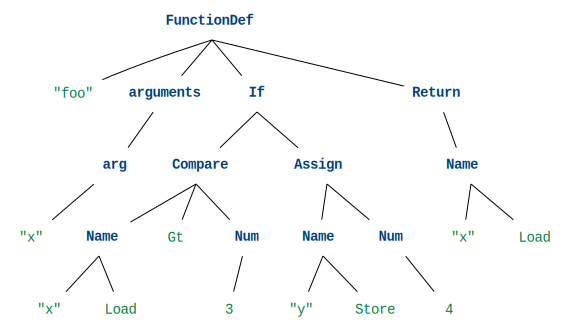

In [126]:
%%showast
def foo(x):
    if x > 3:
        y = 4
    return x

In [122]:
def foo(x):
    x = 4
    y = 7
    (x,y) = 7,3
    return x

In [162]:
class InterpExpr(ast.NodeVisitor):
    def visit_Compare(self,node):
        if isinstance(node.ops[0], Gt):
            pass
        return
    def visit_Name(self,node):
        return Int(node.id)
    
def interp_expr(e):
    print(e)
    if isinstance(e,ast.Compare):
        if isinstance(e.ops[0], Gt):
            return interp_expr(e.left) > interp_exp(e.comparators[0])
    if isinstance(e, ast.Name):
        return Int(e.id)
    if isinstance(e, ast.Constant):
        return e.value
    if isinstance(e, ast.Num):
        return IntVal(e.n)

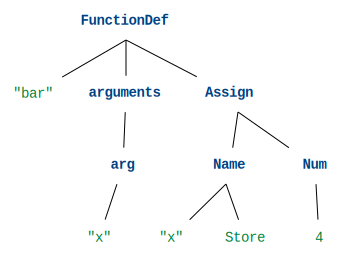

In [163]:
%%showast
def bar(x):
    x = 4

In [165]:

x = Int("x")
class Visty3(ast.NodeVisitor):
    def __init__(self, post):
        self.wp = post
    def generic_visit(self,node):
        #print(node)
        ast.NodeVisitor.generic_visit(self,node)
        return self.wp #st.NodeVisitor.generic_visit(self,node))
    def visit_FunctionDef(self,node):
        for stmt in reversed(node.body):
            #print(stmt)
            ast.NodeVisitor.visit(self,stmt)
    def visit_Assign(self,node):
        print("fuzby")
        lhs = node.targets[0]
        print(interp_expr(node.value))
        self.wp = substitute(self.wp, (Int(lhs.id), interp_expr(node.value)))

def bar(x):
    x = 4


        
Visty3(x >= 4).visit(reflect(bar))
# alternatively, we could trasnform all assignments and if then elses into something overloadable.

fuzby
4


4 >= 4

In [124]:
class Visty(ast.NodeVisitor):
    def visit_FunctionDef(self,node):
        print(node.name)

Visty().visit(reflect(foo))
        
class Visty2(ast.NodeVisitor):
    def generic_visit(self,node):
        print(type(node))
        ast.NodeVisitor.generic_visit(self,node)
Visty2().visit(reflect(foo))   

class Visty3(ast.NodeVisitor):
    def __init__(self):
        self.acc = 0
    def generic_visit(self,node):
        print(node)
        ast.NodeVisitor.generic_visit(self,node)
        return self.acc #st.NodeVisitor.generic_visit(self,node))
    def visit_Name(self,node):
        print(node)
        self.acc += 1
        #ast.NodeVisitor.generic_visit(self,node)
'''        return 1
    def visit_Num(self,node):
        return 0
    def visit_Store(self,node):
        return 0
    def visit_arg(self,node):
        return 0
    def visit_arguments(self,node):
        return 0
    def visit_Return(self,node):
        return 0
        '''
    
Visty3().visit(reflect(foo))

class Visty4(ast.NodeVisitor):
    def generic_visit(self,node):
        print(node)
        ast.NodeVisitor.generic_visit(self,node)
        return self.acc #st.NodeVisitor.generic_visit(self,node))
    def visit_Name(self,node):
        return 1
        #ast.NodeVisitor.generic_visit(self,node)

foo
<class '_ast.Module'>
<class '_ast.FunctionDef'>
<class '_ast.arguments'>
<class '_ast.arg'>
<class '_ast.Assign'>
<class '_ast.Name'>
<class '_ast.Store'>
<class '_ast.Num'>
<class '_ast.Assign'>
<class '_ast.Name'>
<class '_ast.Store'>
<class '_ast.Num'>
<class '_ast.Assign'>
<class '_ast.Tuple'>
<class '_ast.Name'>
<class '_ast.Store'>
<class '_ast.Name'>
<class '_ast.Store'>
<class '_ast.Store'>
<class '_ast.Tuple'>
<class '_ast.Num'>
<class '_ast.Num'>
<class '_ast.Load'>
<class '_ast.Return'>
<class '_ast.Name'>
<class '_ast.Load'>


5

In [108]:
sum(0)

TypeError: 'int' object is not iterable

Joesette - Rosette bnut for julai

So what is the specturm?
Strongest Postcondition
Weakest precondition
Hoare style axiom schema
Model Checking - TLA+ - every program counter replicates variables
SSA style model checking

https://homes.cs.washington.edu/~emina/media/cav19-tutorial/part2.pdf
symbolic execution vs bounded model checking
You could actually explore all paths in the program and hand them off as a conjunction to z3.
It's a choice of where the search happens

"
Control flow atumatoa
vertices are entriues and exits of basic blocks. Joins and branches


The is the CFG, which is small. Printable on your screen
But there is also CFG x Statespace ~ Statespace if your consider the program counter to be part of the state
This is very very large. Rdiciulously so
Edges if execution path between  (x = 0, y = 2) - (x := x + 1) ----->  (x = 1, y = 2)

Start with CFG/CFA. is error node even connected? Yes, probably. Ok. Let's refine the CFG to include some state
Take a path that goes to error node.
Take wp of this path. If SAT, done. Model is execution trace that reaches error node.
If UNSAT, CFG is failing to capture something
Take WP of each branch point starting from the top.
Get the first UNSAT branch point
Propagate this branching condition up using WP to each intermediate node.
Split along path on this property. Each node along path splits into 2, true prop and false prop. Determine refined edges to/from these nodes using local smt query.

rinse repeat.
"






In [79]:
import showast

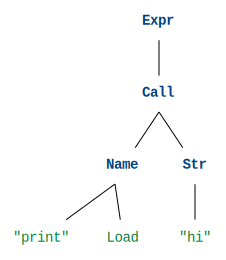

In [80]:
%%showast
print("hi")

In [6]:
IntSeq = SeqSort(IntSort())
# https://theory.stanford.edu/~nikolaj/programmingz3.html#sec-sequences-and-strings

# Unit, Select, Length, Empty, Concat, Nth, indexof,  #https://rise4fun.com/z3/tutorial/sequences
#Unit(IntSeq)
dir(Empty(IntSeq))
a = Const("a", IntSeq)
a + a
Concat(a,a)
dir(a)
solve(Length(a) == 2, a[0] == 4)
#Unit(IntSeq) # crashing?

# Or one can make a list
#List(IntSort())

List = Datatype("MyList")
List.declare("Nil")
List.declare("Cons", ("hd", IntSort()), ("tail", List))
List = List.create()

[a = Concat(Unit(4), Unit(5))]


In [21]:
# would it be better to turn x into a function of time step
#x_fun = Function(str(x), IntSort(), x.sort())
#always = Function("[]", BoolSort(), BoolSort() )
# I can't subsitute always though can i

#diff(x)
def eventually(p, n=20):
    return Not(always(Not(p),n=n))

init = x == 0
nxt = Or(prime(x) == x + 1, prime(x) == x)
spec = init & always(nxt, n = 5)

prove(Implies(spec,  eventually(x > 2, n = 5) ))
#Implies(spec,  eventually(x > 2, n = 4) )


counterexample
[x_2 = 1, x_4 = 2, x_1 = 0, x_3 = 1, x = 0]


In [55]:
def diff(x):
    #diff = Function("diff", RealSort(), RealSort())
    if x.decl().name() == "+":
        (a,b) = x.children()
        return diff(a) + diff(b)
    elif x.decl().name() == "*": 
        (a,b) = x.children()
        return diff(a) * b + a * diff(b)
    elif x.decl().name() == "/": 
        (a,b) = x.children()
        return diff(a) * b + a * diff(b)
    elif is_const(x): 
          if x.decl().kind() == Z3_OP_UNINTERPRETED:
                return Function("diff", RealSort(), RealSort())(x)
          else:
                return 0
    elif is_real(x):
        return 0
simplify(diff(x*y*y*3 + 8 * x))

3*y*(y*diff(x) + x*diff(y)) + 3*x*y*diff(y) + 8*diff(x)

In [59]:
is_const(f(x))
is_real(f(x))
dir(f(x))

['__add__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_repr_html_',
 'arg',
 'as_ast',
 'ast',
 'children',
 'ctx',
 'ctx_ref',
 'decl',
 'eq',
 'get_id',
 'hash',
 'is_int',
 'is_real',
 'num_args',
 'params',
 'sexpr',
 'sort',
 'sort_kind',
 'translate',
 'use_pp']

In [40]:
x, y = Reals("x y")
dir(x + y)
(x / y).decl().name() == "/" 

True

In [39]:
(x * y * y).children()
f = Function("f", RealSort(), RealSort())
is_const(f(x))

False

In [48]:
is_real((3*x).children()[0])

True

In [35]:
dir(x)

['__add__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_repr_html_',
 'arg',
 'as_ast',
 'ast',
 'children',
 'ctx',
 'ctx_ref',
 'decl',
 'eq',
 'get_id',
 'hash',
 'is_int',
 'is_real',
 'num_args',
 'params',
 'sexpr',
 'sort',
 'sort_kind',
 'translate',
 'use_pp']

In [ ]:
#FIFO



Can i do platzers differnetial thingo?
with uh gordon's thing?


In [ ]:
def match(x,t,S):
    

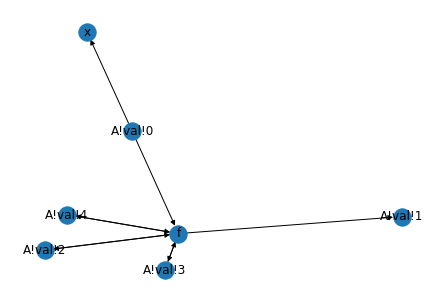

In [123]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
for d in m.decls():
    if d.arity() > 0:
        fmodel = m[d].as_list()
        for entry in fmodel[:-1]:
            G.add_edge(entry[-1], f)
            for invar in entry[:-1]:
                G.add_edge(f,invar)
        for 
    else:
        G.add_edge(m[d], d)
nx.draw(G, with_labels=True)

In [148]:
m[f]

[A!val!1 -> A!val!2,
 A!val!2 -> A!val!3,
 A!val!3 -> A!val!4,
 A!val!4 -> A!val!0,
 else -> A!val!1]

In [147]:
from itertools import product
list(product(*[ m[f.domain(narg)] for narg in range(f.arity())  ]))

[(A!val!4,), (A!val!1,), (A!val!3,), (A!val!0,), (A!val!2,)]

In [111]:
list(match_top(m, [x], f(f(f(x)))))

[{x: A!val!1}, {x: A!val!2}]

In [100]:
def myeg():
    yield 1

for i in myeg():
    print(i)

1


In [97]:
A    = DeclareSort('A')
x, y = Consts('x y', A)
f    = Function('f', A, A)
dir(f(x))
f(x).children()

[x]

unfortunately, if we have to do the matching ourselves, it feels like we aren't getting much out of z3.
Well, we're getting an egraph.



In [98]:
dir(m)
m.decls()
print(type(m[f]))
print(m[x])
type(m[x])
print(dir(m[f]))
print(m[f].as_list())


<class 'z3.z3.FuncInterp'>
A!val!0
['__class__', '__copy__', '__deepcopy__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_repr_html_', 'arity', 'as_list', 'ctx', 'else_value', 'entry', 'f', 'num_entries', 'translate', 'use_pp']
[[A!val!1, A!val!2], [A!val!2, A!val!3], [A!val!3, A!val!4], [A!val!4, A!val!0], A!val!1]


I could reconstruct the graph, find patterns, instantiate them. That's a little ridiculous though

The values in the model ~ equivalence classes of terms.
We can build a reversal map



unsat cores. Could i use this to find instantiations?

refiy9ing into networkx



